In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -R ego-rnn; git clone https://github.com/rm-wu/ego-rnn.git

Cloning into 'ego-rnn'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 269 (delta 5), reused 7 (delta 4), pack-reused 255
Receiving objects: 100% (269/269), 81.86 KiB | 551.00 KiB/s, done.
Resolving deltas: 100% (170/170), done.


In [ ]:
%cd ..

/content


In [ ]:
def plot_confusion_matrix(true, predicted, labels):
    true = torch.cat(true, dim=0)
    predicted =[p.to('cpu') for p in  predicted]
    predicted = torch.cat(predicted, dim=0) 
    cnf_matrix = confusion_matrix(true, predicted, normalize='true').astype(float)
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,
                              display_labels=labels)
    fig, ax = plt.subplots(figsize=(15, 15))
    disp.plot(include_values=False, cmap='Blues', ax=ax, xticks_rotation='vertical')
    ax.grid(True)
    plt.show()

In [ ]:
%cd /content/ego-rnn/
from __future__ import print_function, division
#from twoStreamModel import *
from objectAttentionModelConvLSTM import *
#from flow_resnet import *
from spatial_transforms import (Compose, ToTensor, CenterCrop, Scale, Normalize, MultiScaleCornerCrop,
                                RandomHorizontalFlip)
#from makeDatasetTwoStream import *
#from MakeDatasetFlow import *
from makeDatasetRGB import *
import argparse
import sys
import time
import tqdm
import os

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import ListedColormap

DEVICE = 'cuda'


#dict_path = "../drive/MyDrive/twoStream/16_frame_new_uniform/gtea61/twoStream/model_twoStream_state_dict.pth"
#dict_path = "../drive/MyDrive/MS_Task/Regression/SmoothL1/frames_25_1/50_100/stage2/model_rgb_state_dict.pth"
dict_path = "../drive/MyDrive/rgb_25/gtea61/rgb/stage2/model_rgb_state_dict.pth"
root_dir = "../drive/MyDrive/GTEA61/processed_frames"
seqLen = 25

normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
spatial_transform = Compose([Scale(256), CenterCrop(224), ToTensor(), normalize])

dataset = makeDataset(root_dir, ["S2"], spatial_transform=spatial_transform, seqLen=seqLen)

loader = torch.utils.data.DataLoader(dataset, batch_size=8,
                                               shuffle=False, num_workers=2, pin_memory=True)

#model = twoStreamAttentionModel(flowModel="", frameModel="", stackSize=5, memSize=512, num_classes=61)
model = attentionModel(num_classes=61, mem_size=512)
#model = flow_resnet34(True, channels=2 * 5, num_classes=61)

model.load_state_dict(torch.load(dict_path), strict=False)
model.to(DEVICE)
model.train(False)

valSamples = dataset.__len__()

feats_dict = {i:[] for i in range(61)}
preds = []
true = []

numCorr = 0

preds_t = []
true_t = []

#two stream
path = "../drive/MyDrive/GTEA61/processed_frames/S2"
labels = sorted(os.listdir(path))
''' 
# Two Stream
for j, (inputFlow, inputFrame,  target) in (enumerate(loader)):
    print(j)
    inputVariableFlow = inputFlow.to(DEVICE)
    inputVariableFrame = inputFrame.permute(1, 0, 2, 3, 4).to(DEVICE)
    labelVariable = target.to(DEVICE)
    output_label = model(inputVariableFlow, inputVariableFrame)
    _, predicted = torch.max(output_label.data, 1)
    numCorr += (predicted == target.to(DEVICE)).sum()

    preds_t.append(predicted)
    true_t.append(target)

'''

for j, (inputFrame,  target) in (enumerate(loader)):
    print(j)
    inputVariableFrame = inputFrame.permute(1, 0, 2, 3, 4).to(DEVICE)
    labelVariable = target.to(DEVICE)
    output_label, _ = model(inputVariableFrame)
    _, predicted = torch.max(output_label.data, 1)
    numCorr += (predicted == target.to(DEVICE)).sum()
    preds_t.append(predicted)
    true_t.append(target)

print(preds_t, true_t, labels)

val_accuracy = (numCorr.data.item() / valSamples) * 100
print(val_accuracy)


/content/ego-rnn
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
[tensor([23,  1, 18,  2,  2, 39, 43, 17], device='cuda:0'), tensor([18, 18,  7,  7,  8,  8,  9,  9], device='cuda:0'), tensor([ 9, 30, 35, 23,  1, 14, 14, 14], device='cuda:0'), tensor([ 2, 27, 17, 18, 18, 19, 19, 20], device='cuda:0'), tensor([20, 21, 22, 22, 22, 23, 24, 24], device='cuda:0'), tensor([24, 20, 25, 26, 27, 28, 29, 30], device='cuda:0'), tensor([31, 31, 24, 31, 32, 32, 32, 33], device='cuda:0'), tensor([33, 33, 35, 36, 37, 37, 37, 20], device='cuda:0'), tensor([39, 39, 39, 43, 40, 40, 40, 40], device='cuda:0'), tensor([41, 43, 25, 43, 43, 44, 44, 44], device='cuda:0'), tensor([44, 45, 45, 45, 57, 57, 45,  2], device='cuda:0'), tensor([45, 43, 50, 50, 49, 45, 49, 50], device='cuda:0'), tensor([ 2,  7, 48, 53, 54, 54, 56, 56], device='cuda:0'), tensor([56, 57, 59, 49, 45, 57, 58, 58], device='cuda:0'), tensor([59, 60, 60, 60], device='cuda:0')] [tensor([0, 1, 1, 2, 2, 3, 4, 5]), tensor([6, 6, 7, 7, 8, 8, 9, 9]), tensor([ 

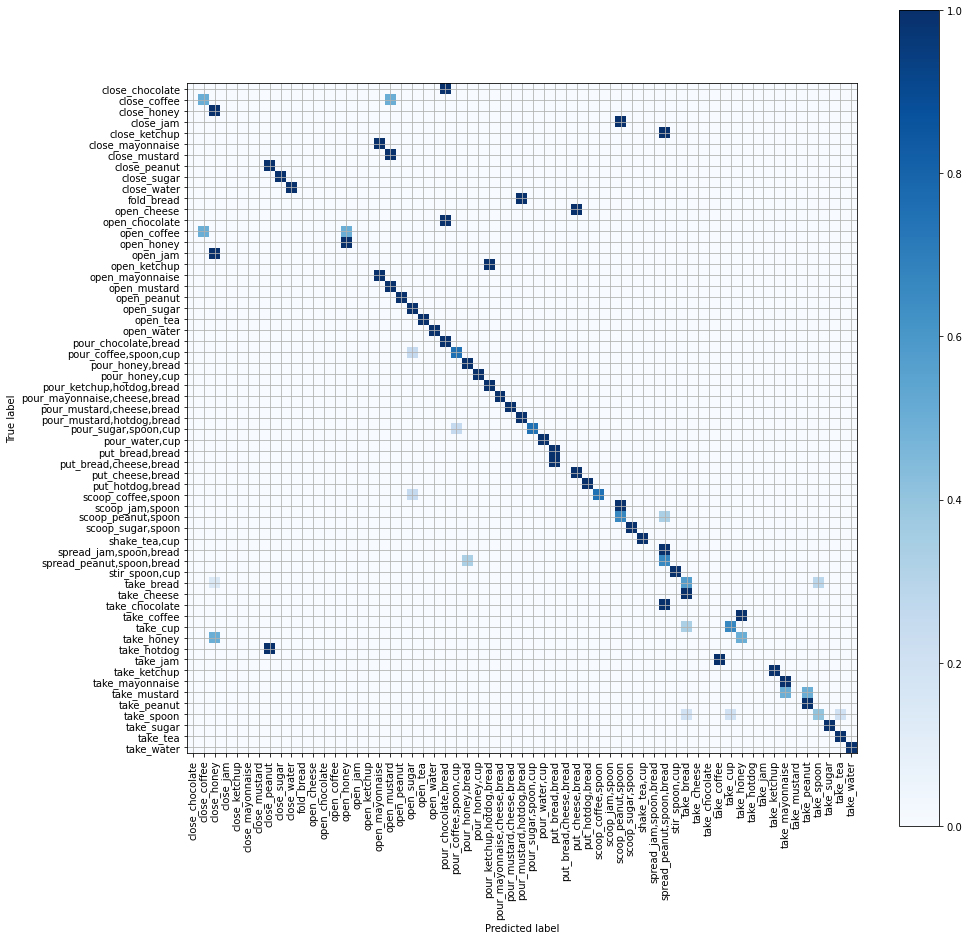

In [ ]:
plot_confusion_matrix(true_t, preds_t, labels)

In [ ]:
%cd ..

/content


In [ ]:
%cd ego-rnn/LSTA_flow/
from __future__ import print_function, division
#from twoStreamModel import *
#from objectAttentionModelConvLSTM import *
#from flow_resnet import *


#flow 
from attentionModelRepFlow import *
#LSTA
#from attentionModel import *
from spatial_transforms import (Compose, ToTensor, CenterCrop, Scale, Normalize, MultiScaleCornerCrop,
                                RandomHorizontalFlip)
#from makeDatasetTwoStream import *
#from makeDatasetFrame import *
from makeDataset import *
from gen_splits import *

import argparse
import sys
import time
import tqdm
import os

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import ListedColormap

DEVICE = 'cuda'


#dict_path = "../../drive/MyDrive/LSTA_1/frames_25_0/1e-4_50_125_E150/stage2/best_checkpoint_stage2.pth.tar"
dict_path = "../../drive/MyDrive/LSTA_1/flow_16/p3_stage2_2/stage2/best_checkpoint_stage2.pth.tar"
root_dir = "../../drive/MyDrive/GTEA61/processed_frames"
seqLen = 16

normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
spatial_transform = Compose([Scale(256), CenterCrop(224), ToTensor(), normalize])

print("here")
trainDatasetF, testDatasetF, trainLabels, testLabels, trainNumFrames, testNumFrames, _ = gen_split(root_dir,
                                                                                                  2)
print("here")
vid_seq_test = makeDataset(testDatasetF, testLabels, testNumFrames,
                            spatial_transform=Compose([Scale(256), CenterCrop(224), ToTensor(), normalize]),
                            fmt='.png', seqLen=seqLen)

loader = torch.utils.data.DataLoader(vid_seq_test, batch_size=1,
                            shuffle=False, num_workers=2, pin_memory=True)



#model = twoStreamAttentionModel(flowModel="", frameModel="", stackSize=5, memSize=512, num_classes=61)
#model = attentionModel(num_classes=61, mem_size=512)
#model = flow_resnet34(True, channels=2 * 5, num_classes=61)

#LSTA
#model = attentionModel(num_classes=61, mem_size=512, c_cam_classes=100)
#LSTA + RepFlow
model = attentionModelRepFlow(num_classes=61, mem_size=512, c_cam_classes=100)

last_checkpoint = torch.load(dict_path)
model.load_state_dict(last_checkpoint['model_state_dict'], strict=True)
model.to(DEVICE)
model.train(False)

valSamples = vid_seq_test.__len__()
print(valSamples)
feats_dict = {i:[] for i in range(61)}
preds = []
true = []

numCorr = 0

preds_t = []
true_t = []

#two stream
path = "../../drive/MyDrive/GTEA61/processed_frames/S2"
labels = sorted(os.listdir(path))

for j, (inputFrame,  target) in (enumerate(loader)):
    print(j)
    inputVariableFrame = inputFrame.permute(1, 0, 2, 3, 4).to(DEVICE)
    labelVariable = target.to(DEVICE)
    output_label, _ = model(inputVariableFrame, 'cuda')
    _, predicted = torch.max(output_label.data, 1)
    numCorr += (predicted == target.to(DEVICE)).sum()
    print(numCorr.data.item())

    #feats_dict[target[0].item()].append(feats.cpu().tolist())
    preds_t.append(predicted)
    true_t.append(target)

    #preds.append(predicted.item())
    #true.append(target.cpu().item())

print(preds_t, true_t, labels)

val_accuracy = (numCorr.data.item() / valSamples) * 100
print(val_accuracy)


#cm = confusion_matrix(true, preds)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#disp.plot()

[Errno 2] No such file or directory: 'ego-rnn/LSTA_flow/'
/content/ego-rnn/LSTA_flow
here
here
116
0
0
1
1
2
1
3
2
4
3
5
4
6
4
7
4
8
4
9
4
10
5
11
6
12
7
13
8
14
9
15
10
16
11
17
12
18
13
19
14
20
15
21
16
22
17
23
18
24
18
25
19
26
20
27
21
28
22
29
23
30
24
31
25
32
26
33
27
34
28
35
28
36
29
37
30
38
31
39
31
40
32
41
32
42
33
43
34
44
35
45
36
46
37
47
37
48
38
49
39
50
39
51
40
52
41
53
42
54
43
55
44
56
45
57
46
58
47
59
48
60
49
61
50
62
51
63
51
64
52
65
53
66
54
67
55
68
56
69
56
70
57
71
58
72
58
73
59
74
60
75
60
76
61
77
62
78
63
79
64
80
65
81
66
82
67
83
68
84
68
85
68
86
68
87
69
88
69
89
69
90
69
91
69
92
70
93
70
94
70
95
71
96
72
97
72
98
72
99
73
100
74
101
75
102
76
103
76
104
76
105
77
106
77
107
78
108
79
109
80
110
80
111
81
112
82
113
83
114
84
115
85
[tensor([12], device='cuda:0'), tensor([1], device='cuda:0'), tensor([3], device='cuda:0'), tensor([2], device='cuda:0'), tensor([2], device='cuda:0'), tensor([3], device='cuda:0'), tensor([51], device='cuda:0'), t

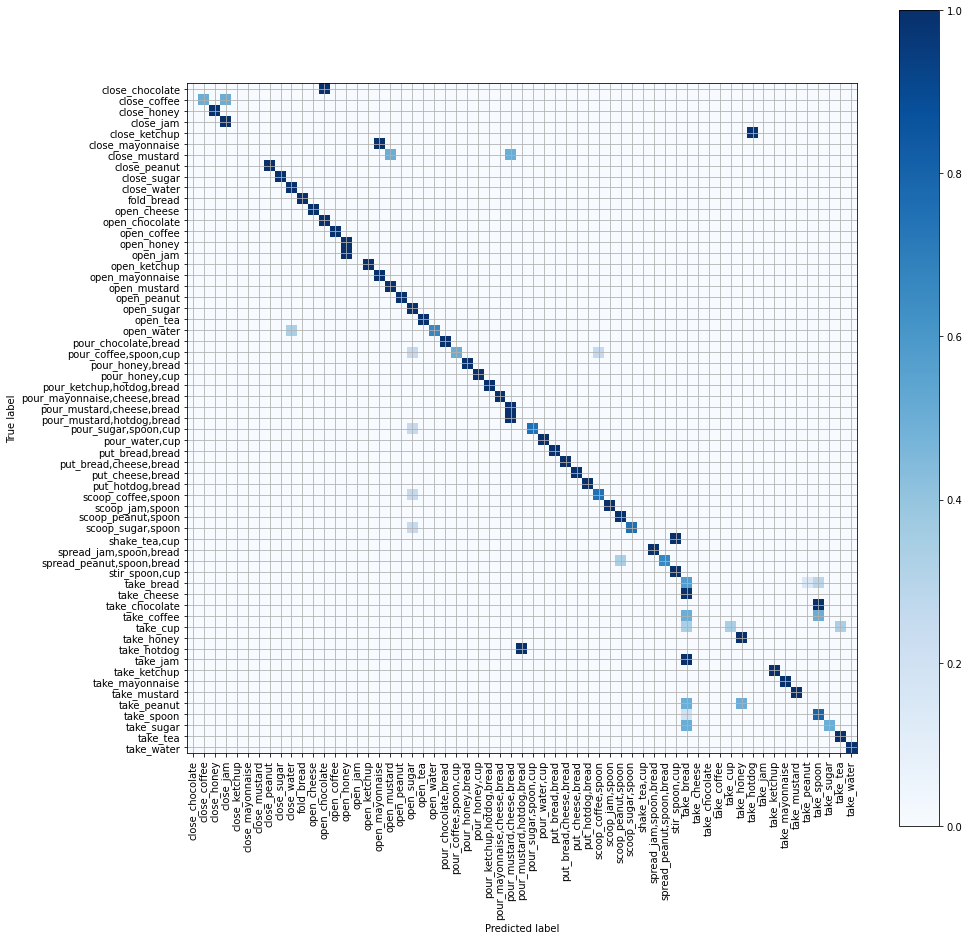

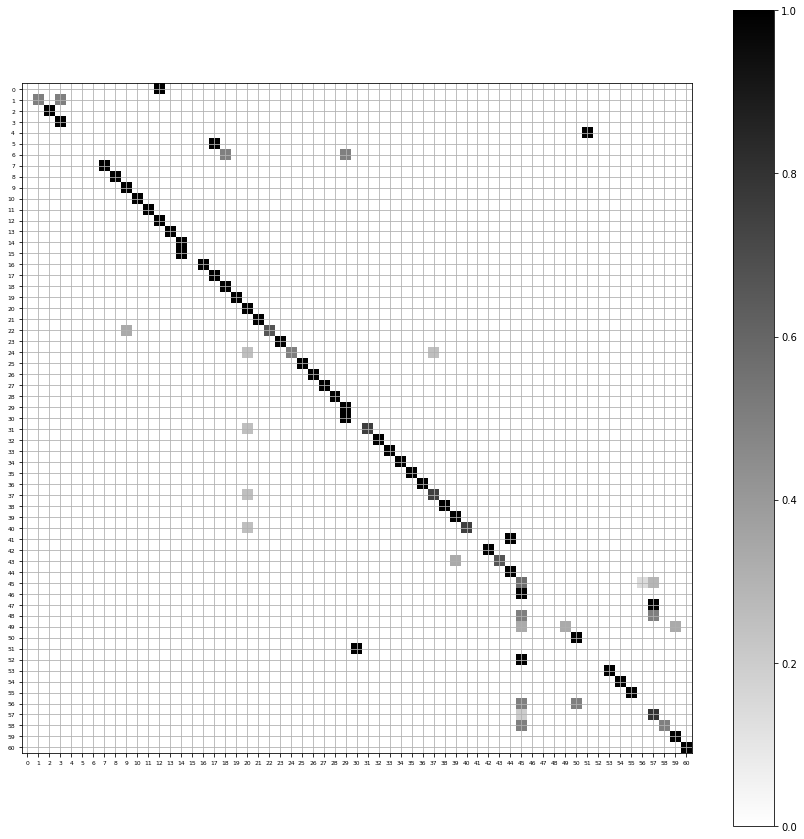

In [ ]:
plot_confusion_matrix(true_t, preds_t, labels)

In [ ]:
%cd ..

/


In [ ]:
%cd /content/ego-rnn
import numpy as np
from torchvision import transforms
import cv2
from objectAttentionModelConvLSTM import *
#from twoStreamModel import *
from attentionMapModel import attentionMap
from PIL import Image
import os
import imageio

DEVICE = "cuda"

# Model definition
num_classes = 61  # Classes in the pre-trained model
mem_size = 512
#model_state_dict = "../drive/MyDrive/rgb_25/gtea61/rgb/stage2/model_rgb_state_dict.pth"
model_state_dict = "../drive/MyDrive/MS_Task/Regression/SmoothL1/frames_25_1/50_100/stage2/model_rgb_state_dict.pth"
#model_state_dict = "drive/MyDrive/twoStream/25_frame_u/gtea61/twoStream/model_twoStream_state_dict.pth"
model = attentionModel(num_classes=num_classes, mem_size=mem_size)
model.load_state_dict(torch.load(model_state_dict), strict=False)
model_backbone = model.resNet
attentionMapModel = attentionMap(model_backbone).to(DEVICE)
attentionMapModel.train(False)
for params in attentionMapModel.parameters():
    params.requires_grad = False

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

preprocess1 = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
])

preprocess2 = transforms.Compose([
    transforms.ToTensor(),
    normalize])

fl_name_in = '../drive/MyDrive/GTEA61/processed_frames/S2/open_jam/1/rgb/'
fl_name_out = '../drive/MyDrive/CAMs/MS_25/S2_open_jam_def'

if os.path.exists(fl_name_out):
    print('Directory {} exists!'.format(fl_name_out))
    sys.exit()
os.makedirs(fl_name_out)

frames = []
for i, img_name in enumerate(sorted(os.listdir(fl_name_in))):
    print(img_name)
    img_pil = Image.open(os.path.join(fl_name_in, img_name))                    
    img_pil1 = preprocess1(img_pil)                                             
    img_size = img_pil1.size
    size_upsample = (img_size[0], img_size[1])
    img_tensor = preprocess2(img_pil1)                                          
    img_variable = img_tensor.unsqueeze(0).to(DEVICE)                 
    img = np.asarray(img_pil1)                                                  
    attentionMap_image = attentionMapModel(img_variable, img, size_upsample)    
    cv2.imwrite(os.path.join(fl_name_out, img_name), attentionMap_image)        
    print(os.path.join(fl_name_out, img_name))
    frames.append(imageio.imread(os.path.join(fl_name_out, img_name)))          

    print(f"frame_{i}")

kargs = {'duration': 0.05}                                                      
imageio.mimsave(fl_name_out + "/frames.gif", frames, **kargs)                   


/content/ego-rnn


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


rgb0001.png
../drive/MyDrive/CAMs/MS_25/S2_open_jam_def/rgb0001.png
frame_0
rgb0002.png
../drive/MyDrive/CAMs/MS_25/S2_open_jam_def/rgb0002.png
frame_1
rgb0003.png
../drive/MyDrive/CAMs/MS_25/S2_open_jam_def/rgb0003.png
frame_2
rgb0004.png
../drive/MyDrive/CAMs/MS_25/S2_open_jam_def/rgb0004.png
frame_3
rgb0005.png
../drive/MyDrive/CAMs/MS_25/S2_open_jam_def/rgb0005.png
frame_4
rgb0006.png
../drive/MyDrive/CAMs/MS_25/S2_open_jam_def/rgb0006.png
frame_5
rgb0007.png
../drive/MyDrive/CAMs/MS_25/S2_open_jam_def/rgb0007.png
frame_6
rgb0008.png
../drive/MyDrive/CAMs/MS_25/S2_open_jam_def/rgb0008.png
frame_7
rgb0009.png
../drive/MyDrive/CAMs/MS_25/S2_open_jam_def/rgb0009.png
frame_8
rgb0010.png
../drive/MyDrive/CAMs/MS_25/S2_open_jam_def/rgb0010.png
frame_9
rgb0011.png
../drive/MyDrive/CAMs/MS_25/S2_open_jam_def/rgb0011.png
frame_10
rgb0012.png
../drive/MyDrive/CAMs/MS_25/S2_open_jam_def/rgb0012.png
frame_11
rgb0013.png
../drive/MyDrive/CAMs/MS_25/S2_open_jam_def/rgb0013.png
frame_12
rgb0014.p

In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys

class attentionMap(nn.Module):
    def __init__(self, backbone, lsta):
        super(attentionMap, self).__init__()
        self.backbone = backbone
        self.mem_size=512
        self.backbone.train(False)
        self.params = list(self.backbone.parameters())
        self.weight_softmax = self.params[-2]
        self.lsta_cell = lsta
        
    def forward(self, img_variable, img, size_upsample, state_att, state_inp):
        if state_att == None: 
            state_att = (torch.zeros(1, 1, 7, 7).cuda(), 
                        torch.zeros(1, 1, 7, 7).cuda())
            state_inp = (torch.zeros((1, self.mem_size, 7, 7)).cuda(),
                    torch.zeros((1, self.mem_size, 7, 7)).cuda())
            
        logit, feature_conv, x = self.backbone(img_variable)
        bz, nc, h, w = feature_conv.size()
        feature_conv = feature_conv.view(bz, nc, h*w)
        probs, idxs = logit.sort(1, True)
        class_idx = idxs[:, 0]
        cam = torch.bmm(self.backbone.fc.weight[class_idx].unsqueeze(1), feature_conv)
        cam=cam.view(x.size(0), 1, 7, 7)
        state_att, state_inp, _ = self.lsta_cell(x, cam, state_att, state_inp)
        s = cam + state_att[1]
        s = F.softmax(s.view(s.size(0), -1), 1)
        cam_img = s
        cam_img = cam_img.cpu().numpy()
        cam_img = cam_img.reshape(h, w)
        cam_img = cam_img - np.min(cam_img)
        cam_img = cam_img / np.max(cam_img)
        cam_img = np.uint8(255 * cam_img)
        output_cam = cv2.resize(cam_img, size_upsample)
        img = cv2.cvtColor(np.uint8(img), cv2.COLOR_RGB2BGR)
        heatmap = cv2.applyColorMap(output_cam, cv2.COLORMAP_JET)
        result = heatmap * 0.3 + img * 0.8
        return result, state_att, state_inp

In [ ]:
%cd /content/ego-rnn/LSTA/
import numpy as np
from torchvision import transforms
import cv2
from attentionModel import *
#from twoStreamModel import *
#from attentionMapModel import attentionMap
from PIL import Image
import os
import imageio

DEVICE = "cuda"

# Model definition
num_classes = 61  # Classes in the pre-trained model
mem_size = 512
#model_state_dict = "../drive/MyDrive/rgb_25/gtea61/rgb/stage2/model_rgb_state_dict.pth"
model_state_dict = "../../drive/MyDrive/LSTA_1/frames_25_0/1e-4_50_125_E150/stage2/best_checkpoint_stage2.pth.tar"
#model_state_dict = "drive/MyDrive/twoStream/25_frame_u/gtea61/twoStream/model_twoStream_state_dict.pth"
model = attentionModel(num_classes=num_classes, mem_size=mem_size, c_cam_classes=100)
model.load_state_dict(torch.load(model_state_dict), strict=False)
model_backbone = model.resNet
attentionMapModel = attentionMap(model_backbone, model.lsta_cell).to(DEVICE)
attentionMapModel.train(False)
for params in attentionMapModel.parameters():
    params.requires_grad = False

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

preprocess1 = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
])

preprocess2 = transforms.Compose([
    transforms.ToTensor(),
    normalize])

fl_name_in = '../../drive/MyDrive/GTEA61/processed_frames/S2/open_jam/1/rgb/'
fl_name_out = '../../drive/MyDrive/CAMs/LSTA/S2_open_jam'

#if os.path.exists(fl_name_out):
#    print('Directory {} exists!'.format(fl_name_out))
#    sys.exit()
os.makedirs(fl_name_out)

frames = []
state_att = None
state_inp = None
for i, img_name in enumerate(sorted(os.listdir(fl_name_in))):
    print(img_name)
    img_pil = Image.open(os.path.join(fl_name_in, img_name))                    
    img_pil1 = preprocess1(img_pil)
    #img_pil1.save(os.path.join(fl_name_out, img_name), "PNG")
    #continue                                             
    img_size = img_pil1.size
    size_upsample = (img_size[0], img_size[1])
    img_tensor = preprocess2(img_pil1)                                         
    img_variable = img_tensor.unsqueeze(0).to(DEVICE)                
    img = np.asarray(img_pil1)   
    attentionMap_image, state_att, state_inp = attentionMapModel(img_variable, 
                                                                 img, 
                                                                 size_upsample, 
                                                                 state_att, 
                                                                 state_inp)
    cv2.imwrite(os.path.join(fl_name_out, img_name), attentionMap_image)        
    print(os.path.join(fl_name_out, img_name))
    frames.append(imageio.imread(os.path.join(fl_name_out, img_name)))  
    print(f"frame_{i}")

kargs = {'duration': 0.05}                                                      
imageio.mimsave(fl_name_out + "/frames.gif", frames, **kargs)                   


/content/ego-rnn/LSTA


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


rgb0001.png
../../drive/MyDrive/CAMs/LSTA/S2_open_jam/rgb0001.png
frame_0
rgb0002.png
../../drive/MyDrive/CAMs/LSTA/S2_open_jam/rgb0002.png
frame_1
rgb0003.png
../../drive/MyDrive/CAMs/LSTA/S2_open_jam/rgb0003.png
frame_2
rgb0004.png
../../drive/MyDrive/CAMs/LSTA/S2_open_jam/rgb0004.png
frame_3
rgb0005.png
../../drive/MyDrive/CAMs/LSTA/S2_open_jam/rgb0005.png
frame_4
rgb0006.png
../../drive/MyDrive/CAMs/LSTA/S2_open_jam/rgb0006.png
frame_5
rgb0007.png
../../drive/MyDrive/CAMs/LSTA/S2_open_jam/rgb0007.png
frame_6
rgb0008.png
../../drive/MyDrive/CAMs/LSTA/S2_open_jam/rgb0008.png
frame_7
rgb0009.png
../../drive/MyDrive/CAMs/LSTA/S2_open_jam/rgb0009.png
frame_8
rgb0010.png
../../drive/MyDrive/CAMs/LSTA/S2_open_jam/rgb0010.png
frame_9
rgb0011.png
../../drive/MyDrive/CAMs/LSTA/S2_open_jam/rgb0011.png
frame_10
rgb0012.png
../../drive/MyDrive/CAMs/LSTA/S2_open_jam/rgb0012.png
frame_11
rgb0013.png
../../drive/MyDrive/CAMs/LSTA/S2_open_jam/rgb0013.png
frame_12
rgb0014.png
../../drive/MyDrive/CAM

In [ ]:
 !rm -R ../../drive/MyDrive/CAMs/LSTA/S2close_chocolate_def/

rm: cannot remove '../../drive/MyDrive/CAMs/LSTA/S2close_chocolate_def/': No such file or directory


In [ ]:
%cd /content/ego-rnn/LSTA_flow/
import numpy as np
from torchvision import transforms
import cv2
from attentionModelRepFlow import *
#from twoStreamModel import *
#from attentionMapModel import attentionMap
from PIL import Image
import os
import imageio

DEVICE = "cuda"

# Model definition
num_classes = 61  # Classes in the pre-trained model
mem_size = 512
model_state_dict = "../../drive/MyDrive/LSTA_1/flow_16/p3_stage2_2/stage2/best_checkpoint_stage2.pth.tar"
model = attentionModelRepFlow(num_classes=num_classes, mem_size=mem_size, c_cam_classes=100)
model.load_state_dict(torch.load(model_state_dict), strict=False)
model_backbone = model.resNet
attentionMapModel = attentionMap(model_backbone, model.lsta_cell).to(DEVICE)
attentionMapModel.train(False)
for params in attentionMapModel.parameters():
    params.requires_grad = False

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

preprocess1 = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
])

preprocess2 = transforms.Compose([
    transforms.ToTensor(),
    normalize])

fl_name_in = '../../drive/MyDrive/GTEA61/processed_frames/S1/open_jam/1/rgb/'
fl_name_out = '../../drive/MyDrive/CAMs/LSTA_flow/S1_open_jam'

#if os.path.exists(fl_name_out):
#    print('Directory {} exists!'.format(fl_name_out))
#    sys.exit()
os.makedirs(fl_name_out)

frames = []
state_att = None
state_inp = None
for i, img_name in enumerate(sorted(os.listdir(fl_name_in))):
    print(img_name)
    img_pil = Image.open(os.path.join(fl_name_in, img_name))                    
    img_pil1 = preprocess1(img_pil)
    #img_pil1.save(os.path.join(fl_name_out, img_name), "PNG")
    #continue                                             
    img_size = img_pil1.size
    size_upsample = (img_size[0], img_size[1])
    img_tensor = preprocess2(img_pil1)                                         
    img_variable = img_tensor.unsqueeze(0).to(DEVICE)                
    img = np.asarray(img_pil1)   
    attentionMap_image, state_att, state_inp = attentionMapModel(img_variable, 
                                                                 img, 
                                                                 size_upsample, 
                                                                 state_att, 
                                                                 state_inp)
    cv2.imwrite(os.path.join(fl_name_out, img_name), attentionMap_image)        
    print(os.path.join(fl_name_out, img_name))
    frames.append(imageio.imread(os.path.join(fl_name_out, img_name)))  
    print(f"frame_{i}")

kargs = {'duration': 0.05}                                                      
imageio.mimsave(fl_name_out + "/frames.gif", frames, **kargs)                   


/content/ego-rnn/LSTA_flow


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


FileNotFoundError: ignored